In [ ]:
#| hide
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


# Cross-validation

:::{.callout-warning collapse="true"}
## Prerequesites
This Guide assumes basic familiarity with NeuralForecast. For a minimal example visit the [Quick Start](../getting-started/02_quickstart.ipynb)
:::

To measure the performance of forecasting model, we can assess its performance on historical data using *cross-validation*.

Cross-validation is done by defining a sliding window of input data to predict the following period. We do this operation many times such that the model predicts new periods, resulting in a more robust assessment of its performance.

Below, you can see an illustration of cross-validation. In this illustration, the cross-validation process generates six different forecasting periods where we can compare the model's predictions against the actual values of the past. 

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

This mimicks the process of making predictions in the future and collecting actual data to then evaluate the prediction's accuracy.

In this tutorial, we explore in detail the cross-validation function in `neuralforecast`.

## 1. Libraries

Make sure to install `neuralforecast` to follow along.

In [ ]:
%%capture
!pip install neuralforecast

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

os.environ['NIXTLA_ID_AS_COL'] = '1'
os.environ['PL_DISABLE_FORK'] = '1'

## 2. Read the data

For this tutorial, we use part of the hourly M4 dataset. It is stored in a parquet file for efficiency. You can use ordinary pandas operations to read your data in other formats likes `.csv`. 

The input to `NeuralForecast` is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestampe ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast. 
We will rename the 

This data set already satisfies the requirement.  

Depending on your internet connection, this step should take around 10 seconds. 

In [ ]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


For simplicity, we use only a single series to explore in detail the cross-validation functionality. Also, let's use the first 700 time steps, such that we work with round numbers, making it easier to visualize and understand cross-validation.

In [ ]:
Y_df = Y_df.query("unique_id == 'H1'")[:700]
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


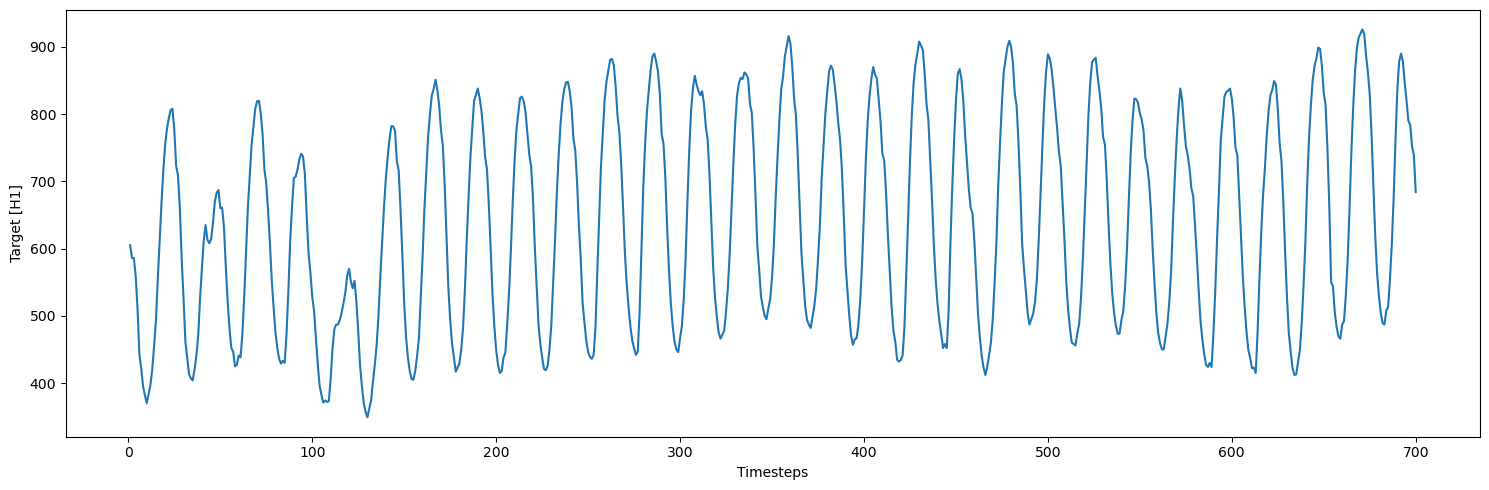

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.xlabel('Timesteps')
plt.ylabel('Target [H1]')
plt.tight_layout()

## 3. Using cross-validation
### 3.1 Using `n_windows`

To use the `cross_validation` method, we can either:
- Set the sizes of a validation and test set
- Set a number of cross-validation windows

Let's see how it works in a minimal example. Here, we use the NHITS model and set the horizon to 48h, and give an input size of 96h.

First, let's use `n_windows = 4`.

We also set `step_size` equal to the horizon. This parameter controls the distance between each cross-validation window. By setting it equal to the horizon, we perform *chained cross-validation* where the windows do not overlap.

In [ ]:
h = 100
nf = NeuralForecast(models=[NHITS(h=h, input_size=2*h, max_steps=500, enable_progress_bar=False, logger=False)], freq=1);
cv_df = nf.cross_validation(Y_df, n_windows=4, step_size=h, verbose=0);

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/torch/nn/functional.py:3954: UserWarning: The operator 'aten::upsample_linear1d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.upsample_linear1d(input, output_size, align_corners, scale_factors)
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
cv_df.head()

,unique_id,ds,cutoff,NHITS,y
0,H1,301,300,491.435852,485.0
1,H1,302,300,539.435547,525.0
2,H1,303,300,612.131287,585.0
3,H1,304,300,689.817200,670.0
4,H1,305,300,761.155945,747.0


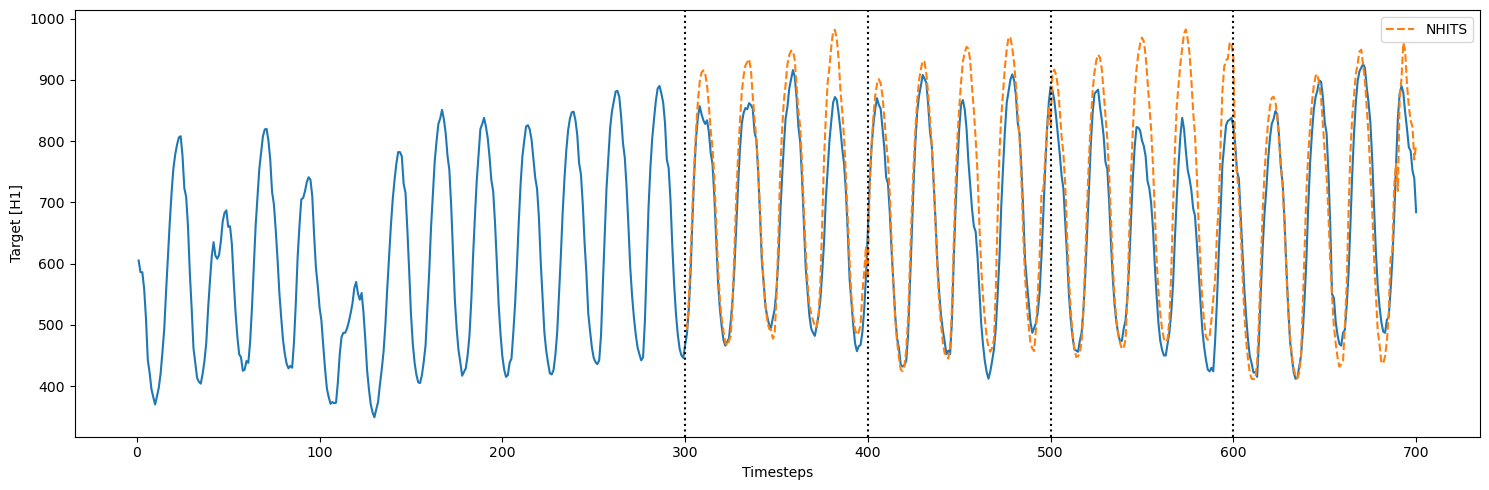

In [ ]:
cutoffs = cv_df['cutoff'].unique()

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(cv_df['ds'], cv_df['NHITS'], label='NHITS', ls='--')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Timesteps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()

In the figure above, we see that we have 4 cutoff points, which correspond to our four cross-validation windows. Of course, notice that the windows are set from the end of the dataset. That way, the model trains on past data to predict future data. Thus, the model was trained using the first 300 time steps, and it started making predictions for the period from 301st time step to 400th time steps.

Then, the actual values from 200 to 400 (because our model has an `input_size` of 200) was used to generate predictions over the next window, from 401 to 500. 

This process is repeated until we run out of windows. 

### 3.2 Using a validation and test set

Instead of setting a number of windows, we can define a validation and test set. In that case, we must set `n_windows=None`

In [ ]:
cv_df_val_test = nf.cross_validation(Y_df, val_size=200, test_size=200, step_size=h, n_windows=None);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:1358: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  batch_size = torch.sum(batch_sizes)
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


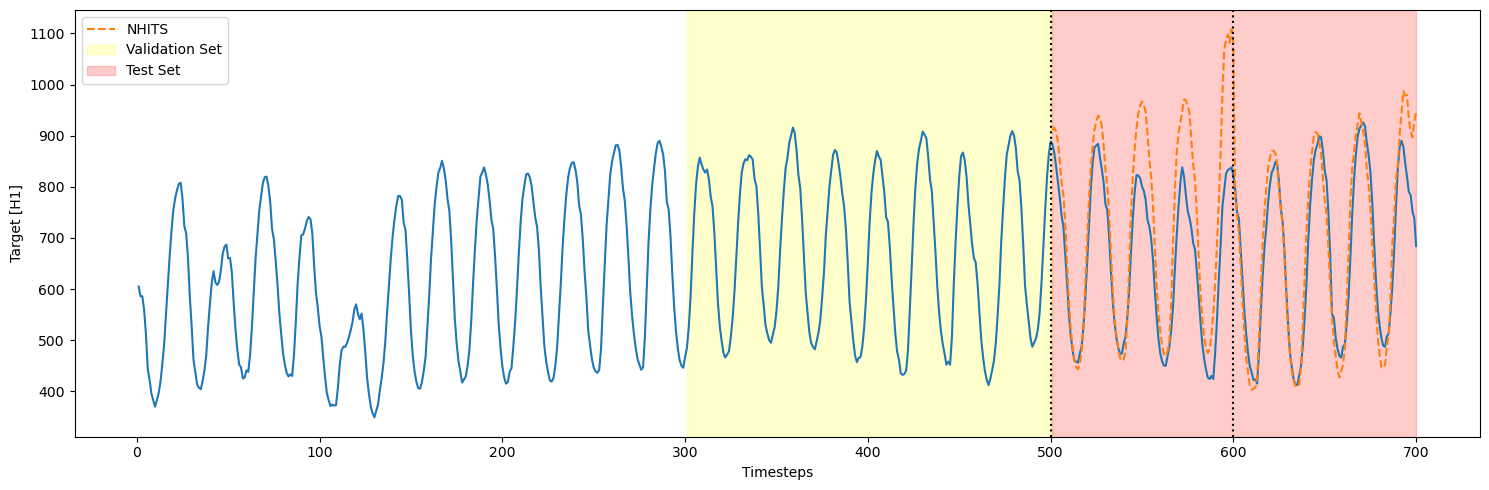

In [ ]:
# cutoffs = cv_df_val_test['cutoff'].unique()

# plt.figure(figsize=(15,5))
# plt.plot(Y_df['ds'], Y_df['y'])
# plt.plot(cv_df_val_test['ds'], cv_df_val_test['NHITS'], label='NHITS', ls='--')

# for cutoff in cutoffs:
#     plt.axvline(x=cutoff, color='black', ls=':')

# plt.xlabel('Timesteps')
# plt.ylabel('Target [H1]')
# plt.legend()
# plt.tight_layout()

cutoffs = cv_df_val_test['cutoff'].unique()
plt.figure(figsize=(15,5))

# Plot the original data and NHITS predictions
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(cv_df_val_test['ds'], cv_df_val_test['NHITS'], label='NHITS', ls='--')

# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[300], Y_df['ds'].iloc[499], alpha=0.2, color='yellow', label='Validation Set')
plt.axvspan(Y_df['ds'].iloc[500], Y_df['ds'].iloc[699], alpha=0.2, color='red', label='Test Set')

# Add vertical lines for cutoffs
for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

# Set labels and legend
plt.xlabel('Timesteps')
plt.ylabel('Target [H1]')
plt.legend()

plt.tight_layout()
plt.show()

Here, we see that predictions are done only on the test set, which corresponds to the last 200 time steps. Since the model has a forecast horizon of 100, and `step_size` is also set to 100, there are only two cross-validation windows in the test size (200/100 = 2). Thus, we see only two cutoff points.

### 3.3 Cross-validation with refit
In the previous sections, we trained the model only once and predicted over many cross-validation windows. However, in real life, we often retrain our model with new observed data before making the next set of predictions.

We can simulate that process using `refit=True`. That way, the model is retrained at every step in the cross-validation process. In other words, the training set is gradually expanded with new observed values and the model is retrained before making the next set of predictions.

In [ ]:
cv_df_refit = nf.cross_validation(Y_df, n_windows=4, step_size=h, refit=True);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, 

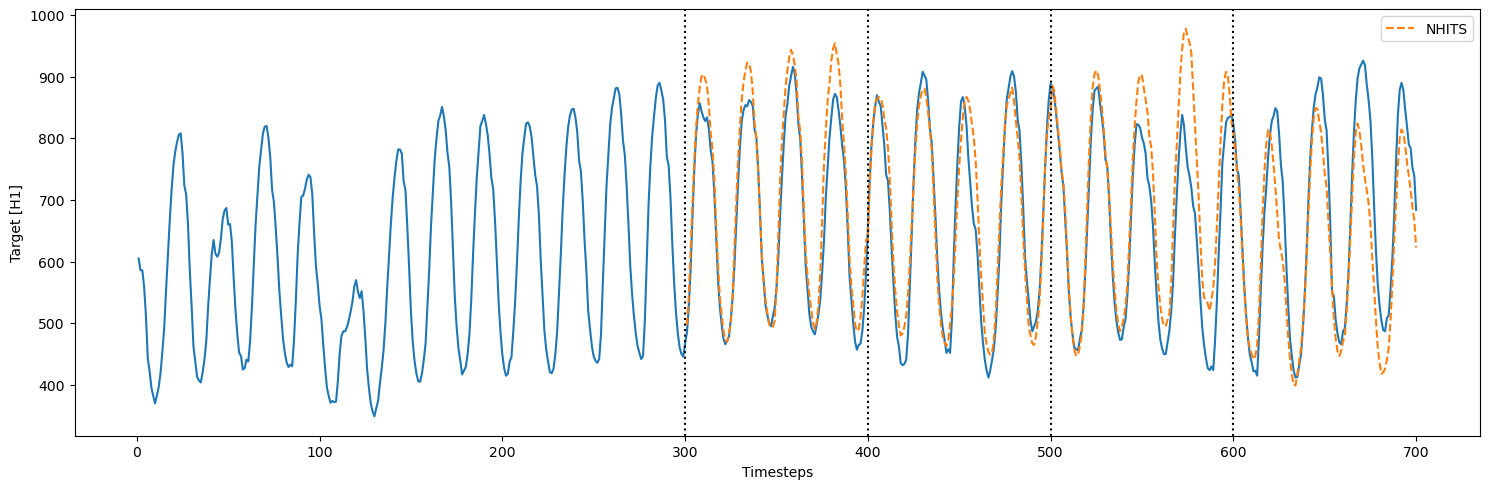

In [ ]:
cutoffs = cv_df_refit['cutoff'].unique()

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(cv_df_refit['ds'], cv_df_refit['NHITS'], label='NHITS', ls='--')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Timesteps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()

Notice that when we run cross-validation with `refit=True`, there were 4 training loops that were completed. This is expected because the model is now retrained with new data for each fold in the cross-validation:
- fold 1: train on the first 300 steps, predict the next 100
- fold 2: train on the first 400 steps, predict the next 100
- fold 3: train on the first 500 steps, predict the next 100,
- fold 4: train on the first 600 steps, predict the next 100

### 3.4 Overlapping windows in cross-validation

In the case where `step_size` is smaller than the horizon, we get overlapping windows. This means that we make predictions more than once for some time steps. 

This is useful to test the model over more forecast windows, and it provides a more robust evaluation, as the model is tested across different segement of the series.

However, it comes with a higher computation cost, as we are making predictions more than once for some of the time steps.

In [ ]:
cv_df_refit_overlap = nf.cross_validation(Y_df, n_windows=2, step_size=50, refit=True);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


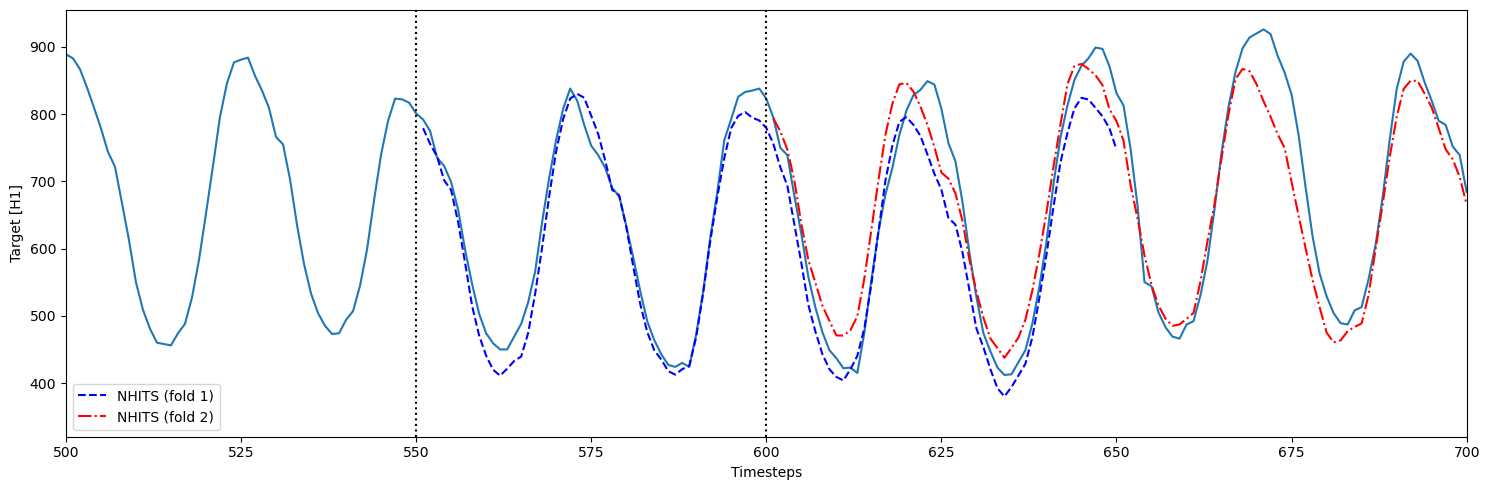

In [ ]:
cutoffs = cv_df_refit_overlap['cutoff'].unique()

fold1 = cv_df_refit_overlap.query("cutoff==550")
fold2 = cv_df_refit_overlap.query("cutoff==600")

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(fold1['ds'], fold1['NHITS'], label='NHITS (fold 1)', ls='--', color='blue')
plt.plot(fold2['ds'], fold2['NHITS'], label='NHITS (fold 2)', ls='-.', color='red')

for cutoff in cutoffs:
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Timesteps')
plt.ylabel('Target [H1]')
plt.xlim(500, 700)
plt.legend()
plt.tight_layout()

In the figure above, we see that our two folds overlap between time steps 601 and 650, since the step size if 5-. This make sense because:
- fold 1: model is trained using time steps 0 to 550 and predicts 551 to 650 (h=100)
- fold 2: model is trained using time steps 0 to 600 (`step_size=50`) and predicts 601 to 700

Here, when evaluating the model, know that some time steps will have an unequal weight, since they will have more predictions than other time steps. Therefore, your evaluation will be slightly biased because some dates have more than one prediction. This is just something to keep in mind when evaluating your models with overlapping cross-validation windows.